In [1]:
import numpy as np
import matplotlib.pyplot as plt
from EMAN2 import *
plt.gray();
floattype=np.float32

<Figure size 432x288 with 0 Axes>

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='0' 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true' 
import tensorflow as tf

In [3]:
#### we will import some functions from e2gmm_refine later
emdir=e2getinstalldir()
sys.path.insert(0,os.path.join(emdir,'bin'))


In [4]:
# lst=load_lst_params("gmm_07/ptcls_bin2.lst")
# dicout=[]
# for l in lst:
#     d=eval(l["lst_comment"])
#     scr=d.pop("score")
#     xf=Transform(d)
#     dc={"src":l["src"], "idx":l["idx"],"xform.projection":xf, "score":scr}
#     dicout.append(dc)
# save_lst_params(dicout, "gmm_11/ptcls_bin2.lst")

In [5]:
#### load particle info
fname="gmm_11/ptcls_bin4.lst"
hdr=EMData(fname,0, True)
apix=hdr["apix_x"]
sz=hdr["ny"]
print(apix, sz)

lst=load_lst_params(fname)
nptcl=len(lst)
xfs=[l["xform.projection"].get_params("eman") for l in lst]
    
xfsnp=np.array([[x["az"],x["alt"],x["phi"], x["tx"], x["ty"]] for x in xfs], dtype=floattype)
xfsnp[:,:3]=xfsnp[:,:3]*np.pi/180.
xfsnp[:,3:]/=sz
print(xfsnp.shape)

3.440000057220459 60
(445874, 5)


-0.08371682381097456 267520


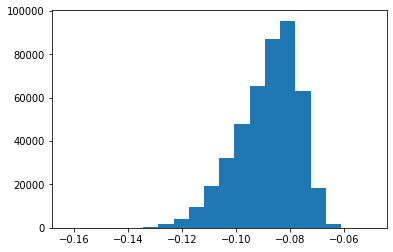

In [6]:
#### remove worse particles, also make sure the particle count is an integer times batch size
score=np.array([x["score"] for x in lst])
plt.hist(score,20);
bsz=32
n=int(len(score)*.6)//bsz*bsz
thr=np.sort(score)[n]
ptclidx=score<thr
print(thr, np.sum(ptclidx))
xfsnp=xfsnp[ptclidx]

In [7]:
#### Here we loaded all particles and ded fft previously and saved fft particles to seperate files
##   load the files here to save time. Calling the load_particles should do the same
data_cpx=[]
sz=hdr["ny"]
for f in ["sets/ptcls_bin4_ftreal.hdf", "sets/ptcls_bin4_ftimag.hdf"]:
    a=EMData(f)
    b=a.numpy()
    b=b[ptclidx]
    print(b.shape, np.max(b))
    data_cpx.append(b.reshape((-1, sz, sz//2+1)).copy())
a=None

(267520, 1860) 1.8091238
(267520, 1860) 1.2353765


In [8]:
from e2gmm_refine import set_indices_boxsz

##   set up fourier indices for image generation/clipping later
##   params is a dictionay that saves matrices for Fourier indexing
maxboxsz=hdr["ny"]

clipid=set_indices_boxsz(data_cpx[0].shape[1], apix, True)
params=set_indices_boxsz(maxboxsz)

##   create an empty options object that is needed for some functions in e2gmm_refine
options=type('options', (object,), {})()
options.sym="c1"


In [9]:
#### model is generated from the map of one state from the last round of GMM
##   so there is solid density for the AHD. The backbone part is built from the backbone model of the protein

pts=np.loadtxt("gmm_11/model_01.txt").astype(floattype)
print("Gaussian model shape: ", pts.shape)

##   convert model to tensorflow format
pts=tf.constant(pts[None,:,:])

Gaussian model shape:  (1456, 5)


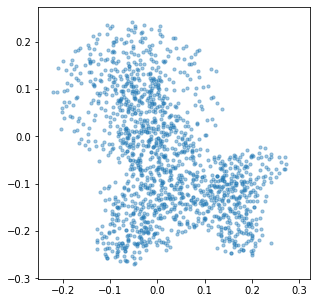

In [10]:
p=pts[0]
plt.figure(figsize=(5,5))
plt.scatter(p[:,0], -p[:,1], alpha=.4, s=10)
plt.axis('square');

0.092530355


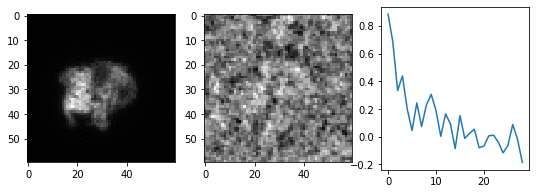

In [11]:
#### now generate some images to make sure everything is working properly
from e2gmm_refine import pts2img, calc_frc, get_clip

sz=params["sz"]    ## size of image
bsz=8              ## batch size

##   generate a batch of projection images from the GMM at neutral state
##   pts2img produce complex images in (real, imag) format
##   turn them into complex numbers and IFT to get the real images
ptsx=tf.Variable(tf.repeat(pts, bsz, axis=0))
imgs_real, imgs_imag=pts2img(ptsx, xfsnp[:bsz], params, lp=.05)
imgs_cpx=imgs_real.numpy().astype(floattype)+1j*imgs_imag.numpy().astype(floattype)
imgs_out=np.fft.irfft2(imgs_cpx)

##   just show one projection-particle comparison
ii=2
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(imgs_out[ii], cmap='gray')

##   get the complex particle image and IFT to real space
dcpx=(data_cpx[0][:bsz], data_cpx[1][:bsz])
dcpx=get_clip(dcpx, sz, clipid)
dcpx_out=np.fft.irfft2(dcpx[0].numpy()+1j*dcpx[1].numpy())

plt.subplot(1,3,2)
plt.imshow(dcpx_out[ii], cmap='gray')

##   calculate FRC between particle and projection
##   the calc_frc function takes complex images in (real, imag) format
frc=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"], True)
plt.subplot(1,3,3)
plt.plot(frc[ii][1:])
fval=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"])
print(np.mean(fval))

In [12]:
##   shrink particles to the requested size
dcpx=get_clip(data_cpx, params["sz"], clipid)
nsample=len(dcpx[0])
print(nsample)
data_cpx=None

267520


(1456, 5)
(106, 5)
(1, 1562, 5)


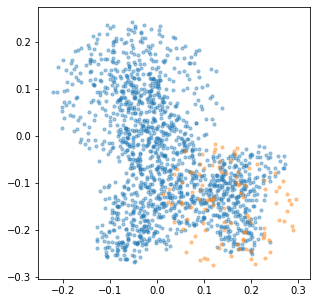

In [13]:
#### in the loaded model, 0-1136 are backbone c-alpha atoms
##   1136-1256 are pseudoatoms generated from the AHD
##   1256-1456 are on the lipd nanodisc

#### here we generate random "phantom" points around the AHD for gradient calculation
x0=1136
x1=x0+120
cnt=np.mean(p[x0:x1], axis=0)[:3]

p=pts[0].numpy()
print(p.shape)
n=200
pe=np.zeros((n,5), dtype=floattype)
pe[:,:3]=np.random.rand(n,3)-.5
pe=pe[np.linalg.norm(pe[:,:3], axis=1)<.5]
pe[:,:3]=pe[:,:3]*.3+cnt
pe[:,3]=1e-3
pe[:,4]=1
print(pe.shape)

plt.figure(figsize=(5,5))
plt.scatter(p[:,0], -p[:,1], alpha=.4, s=10)
plt.scatter(pe[:,0], -pe[:,1], alpha=.4, s=10)
plt.axis('square');

pout=np.vstack([p,pe])[None,:,:]
print(pout.shape)
pts_ref=tf.constant(pout)

Instructions for updating:
Use tf.identity instead.
 33440/33440 : 0.0969         mean score: 0.100


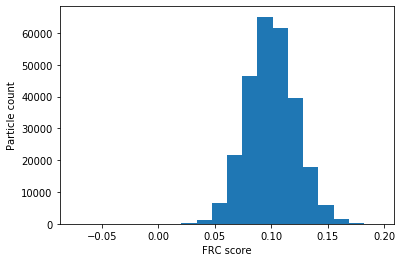

In [14]:
#### calculate d(FRC)/d(GMM) for each particle
##   this will be the input for the deep network in place of the particle images
from e2gmm_refine import calc_gradient

##   prepare training set to be fed into the function
trainset=tf.data.Dataset.from_tensor_slices((dcpx[0], dcpx[1], xfsnp))
trainset=trainset.batch(bsz)
allscr, allgrds=calc_gradient(trainset, pts_ref, params, options)

##   histogram FRC for each particle
plt.hist(allscr, 20);
plt.xlabel("FRC score");
plt.ylabel("Particle count");



In [15]:
#### save gradient so we can skip the gradient calculation step next time

# npt=pts_ref.shape[1]
# allgrds=allgrds.reshape((len(allgrds),-1))
# print("Gradient shape: ", allgrds.shape) 
# ag=from_numpy(np.hstack([allscr[:,None], allgrds]))
# ag.write_image("gmm_11/allgrads_nrm.hdf")
# del ag
# allgrds=allgrds.reshape((len(allgrds), npt, 5))


Gradient shape:  (267520, 7810)


120.0


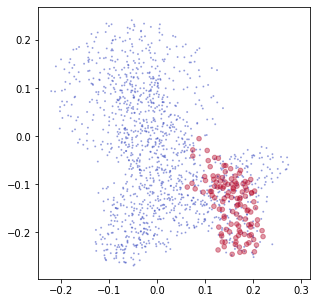

In [16]:
#### create a mask for the AHD
x0=1136
x1=x0+120
npt=pts.shape[1]
p=pts[0,:,:3].numpy()
foci=np.zeros(npt, floattype)
foci[x0:x1]=1.
print(np.sum(foci))
plt.figure(figsize=(5,5))
plt.scatter(p[:,0], -p[:,1], alpha=.4, s=foci*20+1, c=foci, cmap='coolwarm')
# plt.scatter(p[foci==0,0], -p[foci==0,2], alpha=.4)
plt.axis('square');

1136.0


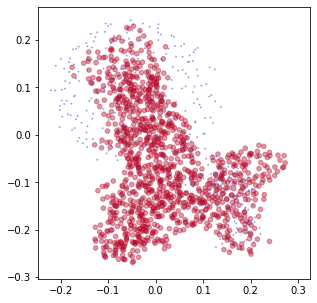

In [17]:
#### mask for backbone model
x0=0
x1=1136

foci_bb=np.zeros(npt, floattype)
foci_bb[x0:x1]=1.
print(np.sum(foci_bb))
plt.figure(figsize=(5,5))
plt.scatter(p[:,0], -p[:,1], alpha=.4, s=foci_bb*20+1, c=foci_bb, cmap='coolwarm')
# plt.scatter(p[foci==0,0], -p[foci==0,2], alpha=.4)
plt.axis('square');

In [18]:
#### rotate-translate a subset of the Gaussian points by a given angle.
##   the angles are in (az, alt, phi, tx, ty, tz)
##   msk is a vector of 1/0 to select the target Gaussians
def rotpts(pts, ang, msk):

    azp=-ang[:,0]*np.pi
    altp=ang[:,1]*np.pi
    phip=-ang[:,2]*np.pi
    trans=ang[:,3:][:,None,:]*.2
    m=msk[None,:,None]

    matrix=tf.stack([(tf.cos(phip)*tf.cos(azp) - tf.cos(altp)*tf.sin(azp)*tf.sin(phip)),
    (tf.cos(phip)*tf.sin(azp) + tf.cos(altp)*tf.cos(azp)*tf.sin(phip)),
    (tf.sin(altp)*tf.sin(phip)),

    (-tf.sin(phip)*tf.cos(azp) - tf.cos(altp)*tf.sin(azp)*tf.cos(phip)),
    (-tf.sin(phip)*tf.sin(azp) + tf.cos(altp)*tf.cos(azp)*tf.cos(phip)),
    (tf.sin(altp)*tf.cos(phip)),

    (tf.sin(altp)*tf.sin(azp)),
    (-tf.sin(altp)*tf.cos(azp)),
    tf.cos(altp)], 0)

    matrix=tf.transpose(matrix)
    matrix=tf.reshape(matrix, shape=[-1, 3,3]) #### Here we get a batch_size x 3 x 3 matrix
    
    cnt=tf.reduce_sum(pts*m, axis=1)[:,None, :]
    cnt=cnt/tf.reduce_sum(m)
    pts_cnt=pts-cnt
    pts_rot=tf.tensordot(pts_cnt, matrix, [[2],[2]])
    pts_rot=tf.transpose(pts_rot, (0,2,1,3))#, (-1, pts.shape[1],3))
    e=tf.eye(pts.shape[0], dtype=bool)#.flatten()
    pts_rot=pts_rot[e]
    
    pts_rot+=cnt
    pts_rot_trans=pts_rot+trans
    
    pts_rot_trans=pts*(1-m)+pts_rot_trans*m
    
    return pts_rot_trans


In [19]:
#### Residue convolution layer for keras
##   alternatively do inverse convolution. not actually used here
##   note for tensorflow 2.0, it refuses to save customized layer to .h5 so we have to save as .tf later
class ResidueConv2D(tf.keras.layers.Layer):
    def __init__(self, nk, sz, activation='linear', transpose=False, **args):
        super(ResidueConv2D, self).__init__()
        if transpose:
            self.conv0=tf.keras.layers.Conv2DTranspose(nk, 1, activation='linear',padding='same', name="conv0")
            self.conv1=tf.keras.layers.Conv2DTranspose(nk, sz, activation='linear',name="conv1", **args)
        else:
            self.conv0=tf.keras.layers.Conv2D(nk, 1, activation='linear',name="conv2",padding='same')
            self.conv1=tf.keras.layers.Conv2D(nk, sz, activation='linear',name="conv3", **args)
        self.nk=nk
        self.act=activation
        self.dropout=tf.keras.layers.Dropout(.3,name="drop0")
        
    def build(self, shp):
        if shp[3]==self.nk:
            self.conv1.build(shp)
            self.skip=True
        else:
            self.conv0.build(shp)
            self.conv1.build([shp[0],shp[1],shp[2],self.nk])
            self.skip=False
        
    def call(self, inp):
        if self.skip:
            out=inp+self.conv1(inp)
                
        else:
            mid=self.conv0(inp)
            out=self.conv1(mid)+mid
            
        if self.act=='relu':
            out=tf.nn.relu(out)
            
        out=self.dropout(out)
        return out
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'conv0': self.conv0,
            'conv1': self.conv1,
            'nk': self.nk,
            'act': self.act,
            'dropout': self.dropout,
            'skip': self.skip,
        })
        return config

In [20]:
#### builde encoder
l2=tf.keras.regularizers.l2(1e-3)
kinit=tf.keras.initializers.RandomNormal(0,1e-4)
ss=64
nout=4

layers=[
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(ss*ss, kernel_regularizer=l2),
    tf.keras.layers.Reshape((ss,ss,1)),

    tf.keras.layers.Conv2D(4, 5, activation="relu", strides=(2,2), padding="same"),
    tf.keras.layers.Conv2D(8, 5, activation="relu", strides=(2,2), padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(nout, kernel_initializer=kinit),
]
encode_model=tf.keras.Sequential(layers)
gd=allgrds[0:10]
mid=encode_model(gd)
print(mid.shape)


(10, 4)


(10, 6)


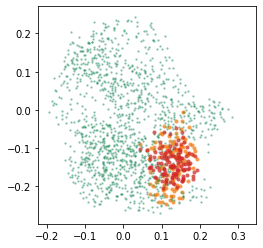

In [21]:
#### build first decoder to rotate-translate the AHD as rigid body
l2=tf.keras.regularizers.l2(4e-2)
kinit=tf.keras.initializers.RandomNormal(0,1e-3)
x0=tf.keras.Input(shape=(mid.shape[1]))

layers=[
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Reshape((16,16,1)),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2DTranspose(16, 3, activation="linear", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(6, activation="tanh",  kernel_regularizer=l2, kernel_initializer=kinit),
]

y0=x0
for l in layers:
    y0=l(y0)

decode_model_rot=tf.keras.Model(x0, y0)
out=decode_model_rot(mid[:20])
print(out.shape)
out=np.zeros(out.shape, dtype=floattype)
out[:,0]+=.5
p0=tf.zeros((out.shape[0],pts.shape[1], 3))+pts[0,:,:3]
out=rotpts(p0, out, foci)  

p=pts[0].numpy()
plt.scatter(p[:,2], -p[:,1], alpha=.2, s=2)
plt.scatter(p[foci>.1,2], -p[foci>.1,1], alpha=.6, s=10)
p=out[0].numpy()
plt.scatter(p[:,2], -p[:,1], alpha=.2, s=2)
plt.scatter(p[foci>.1,2], -p[foci>.1,1], alpha=.6, s=10)
plt.axis('square');


In [22]:
#### build second decoder to morph backbone c-alpha atoms
kinit=tf.keras.initializers.RandomNormal(0,1e-4)
layers=[
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Reshape((16,16,1)),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    ResidueConv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2DTranspose(8, 5, activation="relu", strides=(2,2), padding="same"),
    tf.keras.layers.Conv2DTranspose(4, 5, activation="linear", strides=(2,2), padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(npt*3, activation="linear",  kernel_regularizer=l2, kernel_initializer=kinit, use_bias=False),
    tf.keras.layers.Reshape((npt,3)),
]
decode_model=tf.keras.Sequential(layers)
gd=allgrds[0:10]
mid=encode_model(gd)
out=decode_model(mid)
out.shape

TensorShape([10, 1456, 3])

In [23]:
#### setup training set. 
##   need to set up angle constraints later and for-break seems to be the easiest way to get an item out of the trainset
bsz=32
print(allgrds.shape, dcpx[0].shape, dcpx[1].shape, xfsnp.shape)
trainset=tf.data.Dataset.from_tensor_slices((allgrds, dcpx[0], dcpx[1], xfsnp))
trainset=trainset.batch(bsz)

for grd,pjr,pji,xf in trainset:
    pj_cpx=(pjr, pji)
    conf=encode_model(grd, training=True)#[:,None,:]
    conf=.1*tf.random.normal(conf.shape)+conf
    pout=decode_model(conf, training=True)
    break
    
print(pout.shape)

(267520, 1562, 5) (267520, 60, 31) (267520, 60, 31) (267520, 5)


(1349,)


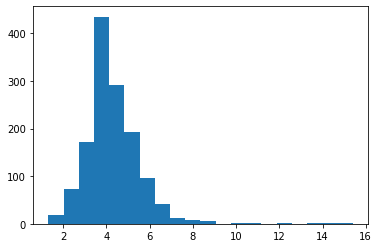

In [25]:
#### load the connection between c-alpha atoms and compute c-alpha distance
##   this is a Mx2 matrix that lists each bond between points

connect=np.loadtxt("gmm_01/model_connect_00.txt").astype(int)
conf=np.zeros((1,1,2), dtype=floattype)

px=tf.gather(pts, connect[:,0], axis=1)[:,:,:3]
py=tf.gather(pts, connect[:,1], axis=1)[:,:,:3]
d=tf.math.sqrt(tf.reduce_sum((px-py)**2, axis=2))
dst00=d[0].numpy().copy()
print(dst00.shape)
d=(d*64*apix).numpy().flatten()
# dr=tf.reduce_mean((d-3.8)**2)
plt.hist(d,20);

(1335, 2)
(1, 1349, 3) (1349, 2) (32, 1456, 3)
(1, 1335, 3) (1, 1335, 3)


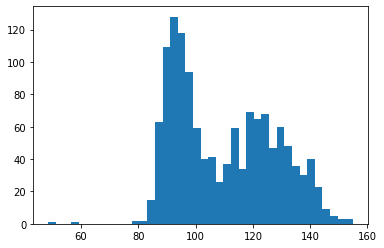

In [26]:
#### compute angle between adjecent bonds
cn2=np.zeros((len(connect)-1, 2), dtype=int)
cn2[:,0]=np.arange(len(cn2))
cn2[:,1]=cn2[:,0]+1
c0=connect[cn2[:,0]]
c1=connect[cn2[:,1]]
cn2=cn2[c0[:,1]==c1[:,0]]
print(cn2.shape)

print(px.shape, connect.shape, pout.shape)
bd=px-py
cx=-tf.gather(bd, cn2[:,0], axis=1)
cy=tf.gather(bd, cn2[:,1], axis=1)
print(cx.shape, cy.shape)
ang=tf.reduce_sum(cx*cy, axis=2)

# ang=tf.linalg.cross(cx, cy)
ang=ang/tf.linalg.norm(cx, axis=2)/tf.linalg.norm(cy, axis=2)
ang00=ang[0].numpy().copy()
ang.shape

a=ang[0].numpy()
a=np.arccos(a)*180/np.pi
plt.hist(a,40);
# plt.xlim(85,95)

In [40]:
#### prepare training. 
##   in the first round, disable decode_model so we start from rigid body motion only
##   then include backbone movement once the initial training converges

opt=tf.keras.optimizers.Adam(learning_rate=1e-4)
wts=[]
allval=[1]
wts+=encode_model.trainable_variables
wts+=decode_model.trainable_variables
wts+=decode_model_rot.trainable_variables

nbatch=len(xfsnp)//bsz


In [41]:
%%time

###########################
##########################
dr=da=0
for itr in range(40):
    
    cost=[]
    val=[]
    for grd,pjr,pji,xf in trainset:
        pj_cpx=(pjr, pji)
        with tf.GradientTape() as gt:
            ## from gradient input to the latent space
            conf=encode_model(grd, training=True)
            
            ## regularization of the latent layer range
            ## ideally the output is within a 1-radius circle
            ## but we want to make the contraint more soft so it won't affect convergence
            cl=tf.math.sqrt(tf.reduce_sum(conf**2, axis=1))
            cl=tf.reduce_mean(tf.maximum(cl-1,0))
            
            ## preturb the conformation by a random value
            ## similar to the variational autoencoder, but we do not train the sigma of the random value here
            ## since we control the radius of latent space already, this seems enough
            conf=.02*tf.random.normal(conf.shape)+conf
            
            ## start from neutral model
            p0=tf.zeros((xf.shape[0],pts.shape[1], 5))+pts
            pout=p0[:,:,:3]
            
            ## rigid body movement of one domain with the first decoder
            rot=decode_model_rot(conf, training=True)
            pout=rotpts(pout, rot, foci)  
            
            ## backbone atom morphing with the second decoder
            pout+=decode_model(conf, training=True)*foci_bb[None,:,None]
            
            ## generate images and calculate frc 
            pout=tf.concat([pout, p0[:,:,3:]], axis=2)
            imgs_cpx=pts2img(pout, xf, params, sym=options.sym)
            fval=calc_frc(pj_cpx, imgs_cpx, params["rings"])

            loss=-tf.reduce_mean(fval)
            
            ## c-alpha distance of current backbone model
            ## use the diviation from the neutral model to regularize the loss
            px=tf.gather(pout, connect[:,0], axis=1)[:,:,:3]
            py=tf.gather(pout, connect[:,1], axis=1)[:,:,:3]
            d=tf.math.sqrt(tf.reduce_sum((px-py)**2, axis=2))
            dr=tf.reduce_mean(abs(d-dst00))
            dr=dr*64*apix
            
            ## angle between c-alpha bonds
            bd=px-py
            cx=-tf.gather(bd, cn2[:,0], axis=1)
            cy=tf.gather(bd, cn2[:,1], axis=1)
            ang=tf.reduce_sum(cx*cy, axis=2)
            ang=ang/tf.linalg.norm(cx, axis=2)/tf.linalg.norm(cy, axis=2)
            da=tf.reduce_mean(abs(ang-ang00))            
            
            ## add regularizers to FRC loss
            l=loss +dr*.001 +da*.001+cl*.001
        
        ## seperate validation set
        if len(cost)<nbatch*.9:
            cost.append([loss, dr, da])
            grad=gt.gradient(l, wts)
            opt.apply_gradients(zip(grad, wts))
        
        else:
            val.append(loss)
        
        sys.stdout.write("\r {}/{}\t{:.3f}\t{:.3f}\t{:.3f}       ".format(len(cost)+len(val), nbatch, loss, dr*10, cl))
        sys.stdout.flush()
        
    sys.stdout.write("\r")
    c=np.mean(cost, axis=0)
    v=np.mean(val)
    print("iter {}, loss : {:.4f}, validate : {:.4f}, bond : {:.4f}, angle : {:.4f}".format(itr, c[0], v, c[1], c[2]))
    
    if v>allval[-1]:
        break

    allval.append(v)

iter 0, loss : -0.1346, validate : -0.1229, bond : 0.9321, angle : 0.2763
iter 1, loss : -0.1379, validate : -0.1237, bond : 1.0750, angle : 0.2882
iter 2, loss : -0.1390, validate : -0.1241, bond : 1.1352, angle : 0.2920
iter 3, loss : -0.1399, validate : -0.1246, bond : 1.1855, angle : 0.2970
iter 4, loss : -0.1408, validate : -0.1245, bond : 1.2258, angle : 0.3016
CPU times: user 2h 33min 42s, sys: 8min 4s, total: 2h 41min 46s
Wall time: 2h 47min 56s


In [42]:
from e2gmm_refine import calc_conf
# #### now look at the latent space
mid=calc_conf(encode_model, allgrds)
print("Latent space shape: ", mid.shape)

## further decompose the latent space to 2d
## here the points fall around two orthogonal axis so ICA seems to be a better choice
from sklearn.decomposition import FastICA

pca=FastICA(2)
p3=pca.fit_transform(mid)

## load particle info
fname2="gmm_11/ptcls_bin2.lst"
ptclinfo=load_lst_params(fname2)
ptclinfo=[p for i,p in enumerate(ptclinfo) if ptclidx[i]]


Latent space shape:  (267520, 4)


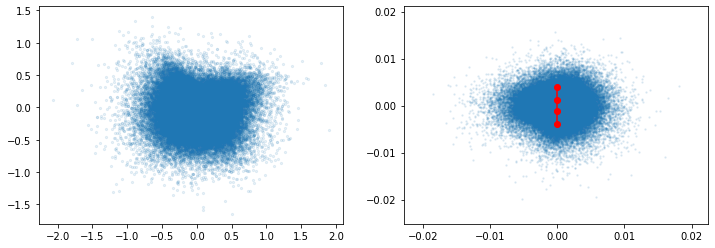

In [52]:
## plot latent space and pca space
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(mid[:,0], mid[:,1],s=5, alpha=.1)

plt.subplot(1,2,2)
plt.scatter(p3[:,0], p3[:,1],s=2,  alpha=.1);


## draw a line in the PCA space to plot the conformation
cnt=np.zeros((4,2))
ax=1
cnt[:,ax]=[-1, -.3, .3, 1]
cnt*=np.std(p3)*2

plt.plot(cnt[:,0], cnt[:,1], 'ro-')

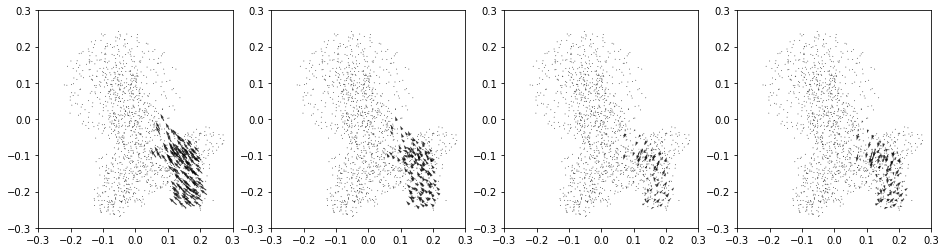

In [53]:
#### look at the GMM conformation along the line in PCA space
pcnt=pca.inverse_transform(cnt)     ## inverse PCA to back to the neural network latent space
pcnt=decode_model_rot(pcnt.astype(floattype))    ## go through the decoder to get the Gaussian model
p=tf.repeat(pts[:,:,:3], len(pcnt), axis=0)
pcnt=rotpts(p, pcnt, foci)  
pcnt=pcnt.numpy()

plt.figure(figsize=(16,4))
for i,p in enumerate(pcnt):
    v=p-pts[0,:,:3]
    plt.subplot(1,4,i+1)
    plt.quiver(pts[0,:,0], -pts[0,:,1], v[:,0], -v[:,1], scale=1, width=5e-3, alpha=.8)
    plt.xlim(-.3,.3)
    plt.ylim(-.3,.3)



In [54]:
#### generate particle subsets from classification
n=6000
for l,p in enumerate(cnt):
#     d=abs(p3[:,ax]-p[ax])
    d=np.linalg.norm(p3-p, axis=1)
    thr=np.sort(d)[n]
    cls=d<thr
    psave=[p for i,p in enumerate(ptclinfo) if cls[i]]
    print("Class {} : {} particles".format(l, len(psave)))
    save_lst_params(psave, "gmm_11/ptcl_mov1_{:02d}_cls_{:02d}.lst".format(ax,l))



Class 0 : 6000 particles
Class 1 : 6000 particles
Class 2 : 6000 particles
Class 3 : 6000 particles


In [55]:
#### reconstruct particles for each class
for i,p in enumerate(cnt):
    launch_childprocess("e2spa_make3d.py --input gmm_11/ptcl_mov1_{:02d}_cls_{:02d}.lst --output gmm_11/threed_mov1_{:02d}_cls_{:02d}.hdf --keep 1 --parallel thread:12 --setsf sf_lp.txt".format(ax,i,ax,i))

In [56]:
decode_model.save_weights("gmm_11/model_decode_01.tf")
decode_model_rot.save_weights("gmm_11/model_decode_rot_01.tf")
encode_model.save_weights("gmm_11/model_encode_01.tf")